# Yelp analiza sentimenta

In [1]:
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    filelock-3.15.4            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.1              |       hb9d3cd8_3         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.9 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.15.4-pyhd8ed1ab_0 
  gdown              conda-forg

[Dataset](https://drive.google.com/file/d/1ihU82zD5LKm8KvgvpSYM_32LC841MFGG/view?usp=sharing)

In [2]:
!gdown 1ihU82zD5LKm8KvgvpSYM_32LC841MFGG

Downloading...
From: https://drive.google.com/uc?id=1ihU82zD5LKm8KvgvpSYM_32LC841MFGG
To: /kaggle/working/balanced_yelp_reviews.csv
100%|██████████████████████████████████████| 95.8M/95.8M [00:03<00:00, 31.2MB/s]


In [3]:
file_path = './balanced_yelp_reviews.csv'

In [4]:
# !gdown 1NikbL1woiW-Jpi-JEtcDQu39E3G6r7NA

In [5]:
# file_path = './output_reviews_top.csv'

In [6]:
import numpy as np
import pandas as pd

import os
import re
import time
import datetime
import string

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter, defaultdict

import transformers
from transformers import BertModel, BertTokenizer, AutoConfig, AutoModel, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
statement_df = pd.read_csv(file_path)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### EDA

In [10]:
statement_df.head()

,statement,sentiment
0,My wife and I were down town for a show and we...,neutral
1,My friends and I had a craving for fried chick...,negative
2,"They have very nice tiles and displays, but th...",negative
3,THE ABSOLUTE WORST! They pretty much charged u...,negative
4,The restaurant by itself was so cute but the b...,neutral


In [11]:
statement_df.shape

(150000, 2)

In [12]:
statement_df.isna().sum()

statement    0
sentiment    0
dtype: int64

In [13]:
print('Number of Duplicate Entries: ', len(statement_df[statement_df.duplicated()]))

Number of Duplicate Entries:  15


In [14]:
statement_df = statement_df.drop_duplicates()

In [15]:
def clean_statements(statement):
    statement = re.sub(" '", "'", statement)
    statement = re.sub(" 's", "'s", statement)
    statement = re.sub('\( ', '(', statement)
    statement = re.sub(' \)', ')', statement)
    statement = re.sub('``', '"', statement)
    statement = re.sub("''", '"', statement)
#     statement = re.sub(r'\s([?.,%:!"](?:\s|$))', r'\1', statement)
    statement = statement.translate(str.maketrans('', '', string.punctuation))
    return statement

In [16]:
statement_df['statement'] = statement_df['statement'].apply(clean_statements)

In [17]:
statement_df['num_char'] = statement_df['statement'].apply(len)
statement_df['num_words'] = statement_df['statement'].apply(lambda x: len(x.split()))

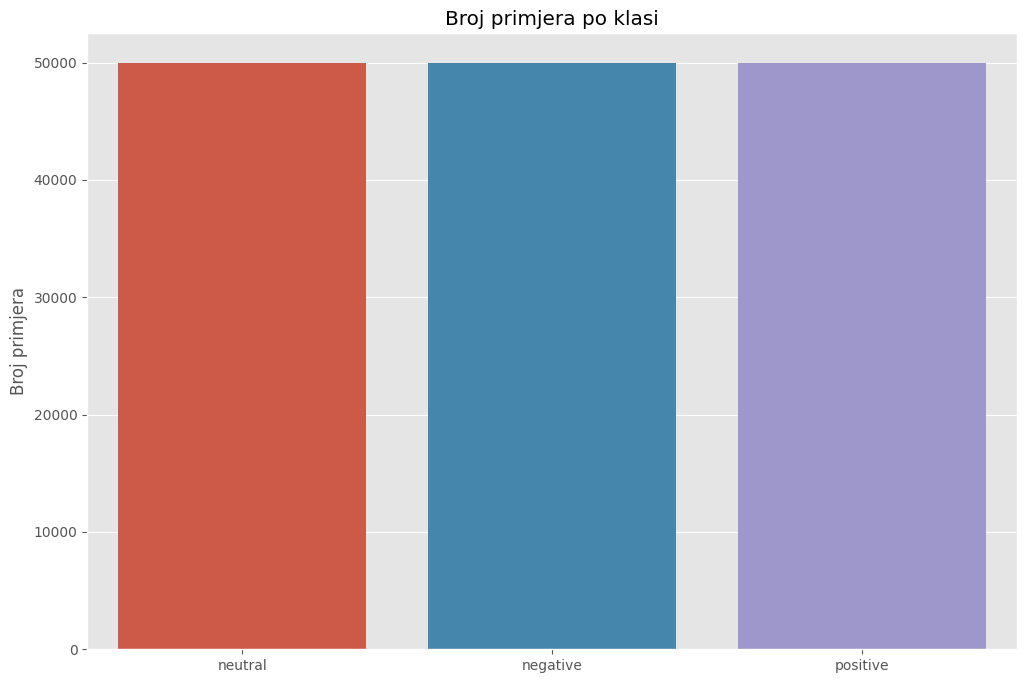

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='sentiment', data=statement_df)
plt.xlabel('')
plt.ylabel('Broj primjera')
plt.title('Broj primjera po klasi')
plt.show()

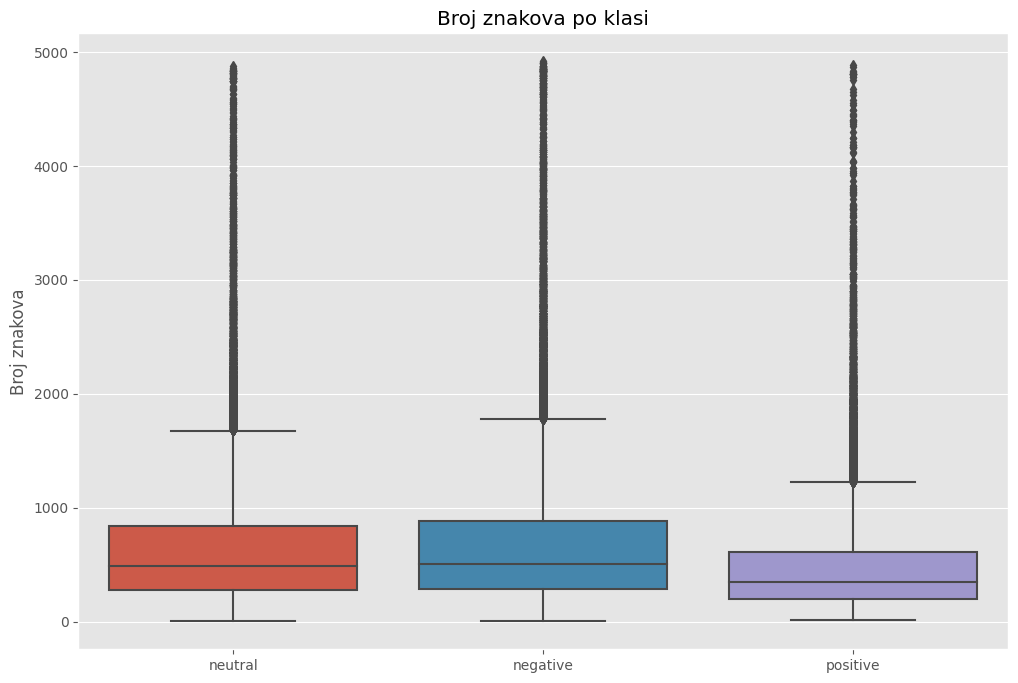

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='sentiment', y='num_char', data=statement_df)
plt.xlabel('')
plt.ylabel('Broj znakova')
plt.title('Broj znakova po klasi')
plt.show()

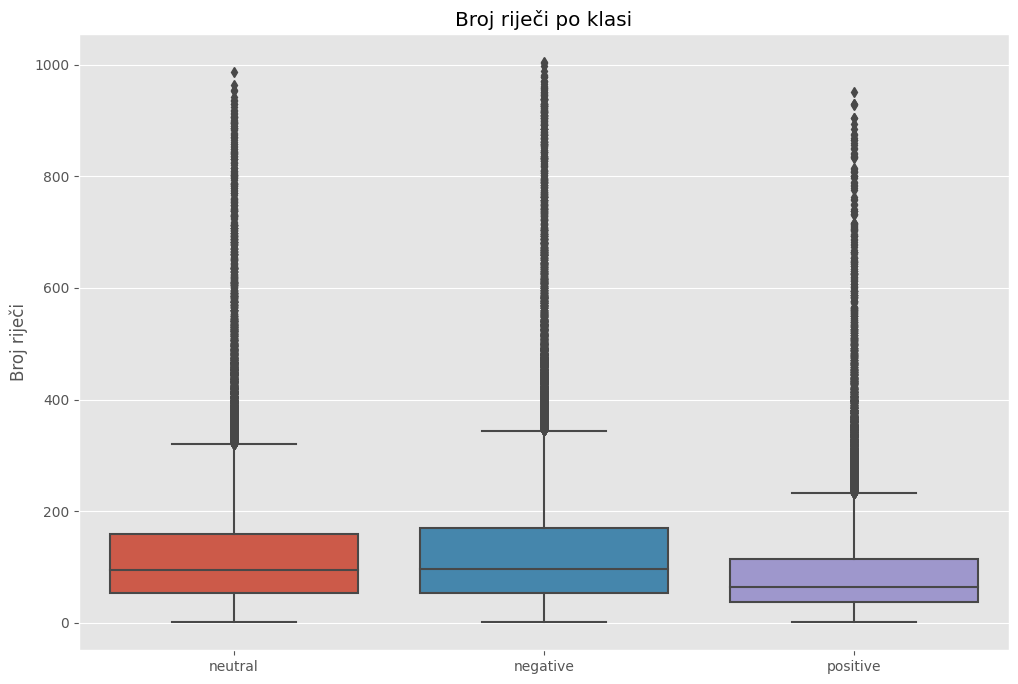

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='sentiment', y='num_words', data=statement_df)
plt.xlabel('')
plt.ylabel('Broj riječi')
plt.title('Broj riječi po klasi')
plt.show()

In [21]:
print('Longest: ', statement_df['num_words'].max(), 'words.')

Longest:  1004 words.


In [22]:
print('Shortest: ', statement_df['num_words'].min(), 'words.')

Shortest:  1 words.


In [23]:
statement_df.describe()

,num_char,num_words
count,149985.000000,149985.000000
mean,607.776578,115.739374
std,550.776543,105.233869
min,4.000000,1.000000
25%,248.000000,47.000000
50%,443.000000,84.000000
75%,777.000000,148.000000
max,4919.000000,1004.000000


In [24]:
pos_statements = ' '.join(statement_df.loc[statement_df['sentiment'] == 'positive']['statement'].values)
neg_statements = ' '.join(statement_df.loc[statement_df['sentiment'] == 'negative']['statement'].values)
neutral_statements = ' '.join(statement_df.loc[statement_df['sentiment'] == 'neutral']['statement'].values)

In [25]:
pos_statements = re.sub('[^A-Za-z]+', ' ', pos_statements).strip().lower()
neg_statements = re.sub('[^A-Za-z]+', ' ', neg_statements).strip().lower()
neutral_statements = re.sub('[^A-Za-z]+', ' ', neutral_statements).strip().lower()

In [26]:
pos_tokens = word_tokenize(pos_statements)
neg_tokens = word_tokenize(neg_statements)
neutral_tokens = word_tokenize(neutral_statements)

In [27]:
stop_words = stopwords.words('english')

In [28]:
pos_tokens_nostop = [w for w in pos_tokens if w not in stop_words]
neg_tokens_nostop = [w for w in neg_tokens if w not in stop_words]
neutral_tokens_nostop = [w for w in neutral_tokens if w not in stop_words]

In [29]:
pos_freq = Counter(pos_tokens_nostop)
neg_freq = Counter(neg_tokens_nostop)
neutral_freq = Counter(neutral_tokens_nostop)

In [30]:
top_10_pos = pos_freq.most_common()[:10]
top_10_neg = neg_freq.most_common()[:10]
top_10_neutral = neutral_freq.most_common()[:10]

In [31]:
def get_ngrams(input, n):
    return [tuple(input[i:i+n]) for i in range(len(input) - n + 1)]

In [32]:
top_10_pos

[('great', 27367),
 ('good', 23453),
 ('food', 23146),
 ('place', 22433),
 ('service', 14472),
 ('time', 13876),
 ('like', 12676),
 ('one', 12453),
 ('get', 12331),
 ('back', 12251)]

In [33]:
top_10_neg

[('food', 28456),
 ('would', 22862),
 ('get', 21822),
 ('service', 21522),
 ('one', 21371),
 ('place', 21239),
 ('time', 21025),
 ('back', 21022),
 ('like', 20294),
 ('good', 17307)]

In [34]:
top_10_neutral

[('good', 39612),
 ('food', 34718),
 ('place', 25478),
 ('like', 23429),
 ('would', 18801),
 ('service', 18720),
 ('get', 17976),
 ('great', 17412),
 ('time', 17257),
 ('one', 17222)]

## Analiza sentimenta

## BERT

In [35]:
MAX_LENGTH = 128
BATCH_SIZE = 8
NUM_CLASSES = 3
EPOCHS = 10
DROPOUT_PROB = 0.3
WEIGHT_DECAY = 0.02
NFOLDS = 10
LEARNING_RATE = 1e-5
EARLY_STOPPING_PATIENCE = 2

In [36]:
le = LabelEncoder()
statement_df['sentiment'] = le.fit_transform(statement_df['sentiment'])

In [37]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [38]:
class StatementDataset(Dataset):

    def __init__(self, statements, labels, tokenizer, max_length):
        self.statements = statements
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):

        return len(self.statements)

    def __getitem__(self, idx):

        statement = str(self.statements[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            statement,
            max_length=self.max_length,
            padding='max_length',
            add_special_tokens=True,
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'statement_text': statement,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [39]:
df_train, df_test = train_test_split(statement_df,
                                     test_size=0.2,
                                     random_state=RANDOM_SEED,
                                     stratify=statement_df['sentiment'].values)

df_train, df_val = train_test_split(df_train,
                                   test_size=0.25,
                                   random_state=RANDOM_SEED,
                                   stratify=df_train['sentiment'].values)

df_train_full = pd.concat([df_train, df_val])

In [40]:
def create_dataset(df, tokenizer, max_length):
    ds = StatementDataset(statements=df['statement'].to_numpy(),
                          labels=df['sentiment'].to_numpy(),
                          tokenizer=tokenizer,
                          max_length=max_length)
    return ds

def create_dataloader(ds, batch_size):
    return DataLoader(ds, batch_size, num_workers=2)

In [41]:
def cv_ensemble_performance(preds, labels):
    preds = np.array(preds)
    summed = np.sum(preds, axis=0)
    preds = np.argmax(summed, axis=1)
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))

def single_model_performance(preds, labels):
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))

In [42]:
def train_model(model, device, data_loader, loss_function,
                optimizer, scheduler, n_examples):

    model = model.train()
    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, labels)
        complete_preds.append(preds.data.cpu().numpy().tolist())
        complete_labels.append(labels.data.cpu().numpy().tolist())
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    complete_preds_flat = [x for y in complete_preds for x in y]
    complete_labels_flat = [x for y in complete_labels for x in y]
    acc_score = accuracy_score(y_true=complete_labels_flat,
                             y_pred=complete_preds_flat)
    return acc_score, np.mean(losses)

In [43]:
def eval_model(model, device, data_loader, loss_function, n_examples):
    model = model.eval()

    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []
    complete_outputs = []

    with torch.no_grad():
        for item in data_loader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, labels)

            correct_preds += torch.sum(preds == labels)
            complete_preds.append(preds.data.cpu().numpy().tolist())
            complete_labels.append(labels.data.cpu().numpy().tolist())
            complete_outputs.append(outputs.tolist())
            losses.append(loss.item())

        accuracy = correct_preds.double() / n_examples
        complete_preds_flat = [x for y in complete_preds for x in y]
        complete_labels_flat = [x for y in complete_labels for x in y]
        complete_outputs_flat = [x for y in complete_outputs for x in y]

        acc_score = accuracy_score(y_true=complete_labels_flat,
                             y_pred=complete_preds_flat)

        return_items = (acc_score,
                        np.mean(losses),
                        complete_preds_flat,
                        complete_outputs_flat)

        return return_items

In [44]:
def train_fold(epochs, model, device, train_dataloader,
               val_dataloader, loss_fn, optimizer,
               scheduler, model_save_name, n_train, n_val, single_model=True):

    start_time = time.time()
    history = defaultdict(list)
    best_accuracy = 0

    early_stopping_patience = EARLY_STOPPING_PATIENCE
    no_improvement_epochs = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        epoch_start_time = time.time()
        print('Epoch ', epoch+1, '/', epochs)
        print('-'*50)

        training_output = train_model(model,
                                      device,
                                      train_dataloader,
                                      loss_fn,
                                      optimizer,
                                      scheduler,
                                      n_train)

        train_acc, train_loss = training_output

        val_output = eval_model(model,
                                device,
                                val_dataloader,
                                loss_fn,
                                n_val)

        val_acc, val_loss, val_preds, val_outputs = val_output

        history['train_accuracy'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_accuracy'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['val_preds'].append(val_preds)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), model_save_name)
            best_accuracy = val_acc
            best_preds = val_preds
            best_outputs = val_outputs

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
            torch.save(bert_model.state_dict(), model_save_name)
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered")
            break

        print(f'Train Loss: {train_loss} | Train Accuracy: {train_acc}')
        print(f'Val Loss: {val_loss} | Val Accuracy: {val_acc}')
        print(f'Epoch Train Time: {format_time(time.time() - epoch_start_time)}')
        print('\n')

    print('Finished Training.')
    print(f'Fold Train Time: {format_time(time.time() - start_time)}')
    print('\n')

    if single_model:
        single_model_performance(best_preds, df_val['sentiment'].values)
        
    return history, best_preds, best_outputs

In [45]:
def get_oof_and_test_preds(model_type, tokenizer,
                           train_df, test_df, single_model=False):
    oof_preds = []
    oof_outputs = []
    oof_preds_indices = []
    test_preds_list = []
    test_outputs_list = []
    history_list = []
    start_time = time.time()

    fold = 0

    x_train = train_df['statement']
    y_train = train_df['sentiment']

    for train_index, val_index in skf.split(x_train, y_train):
        print('Fold: {}'.format(fold+1))

        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_va = x_train.iloc[val_index]
        y_va = y_train.iloc[val_index]

        train = pd.DataFrame(list(zip(x_tr, y_tr)),
                             columns=['statement', 'sentiment'])
        val = pd.DataFrame(list(zip(x_va, y_va)),
                           columns=['statement', 'sentiment'])

        train_ds = create_dataset(train, tokenizer, MAX_LENGTH)
        val_ds = create_dataset(val, tokenizer, MAX_LENGTH)
        test_ds = create_dataset(test_df, tokenizer, MAX_LENGTH)


        if model_type == 'bert':
            model = BERTSentimentClassifier(NUM_CLASSES)
            model = model.to(device)

        train_loader = create_dataloader(train_ds, BATCH_SIZE)
        val_loader = create_dataloader(val_ds, BATCH_SIZE)
        test_loader = create_dataloader(test_ds, BATCH_SIZE)

        training_steps = len(train_loader.dataset) * EPOCHS
        warmup_steps = int(0.1 * training_steps)
        optimizer = optim.AdamW(model.parameters(),
                          lr=LEARNING_RATE,
                          weight_decay=WEIGHT_DECAY)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=warmup_steps,
                                                    num_training_steps=training_steps)

        model_save_name = '{}_fold_{}.bin'.format(model_type, fold)

        history, preds, outputs = train_fold(epochs=EPOCHS,
                                             model=model,
                                             device=device,
                                             train_dataloader=train_loader,
                                             val_dataloader=val_loader,
                                             test_dataloader=test_loader,
                                             loss_fn=loss_function,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             model_save_name=model_save_name,
                                             n_train=len(train),
                                             n_val=len(val),
                                             single_model=False
                                            )

        history_list.append(history)
        oof_preds.append(preds)
        oof_outputs.append(outputs)
        oof_preds_indices.append(val_index)
        _, _, test_preds, test_outputs = eval_model(model,
                                                    device,
                                                    test_loader,
                                                    loss_function,
                                                    len(test_df))
        test_preds_list.append(test_preds)
        test_outputs_list.append(test_outputs)

        fold += 1

    print(str(NFOLDS), 'Fold CV Train Time: ', format_time(time.time() - start_time))

    return history_list, test_outputs_list

In [46]:
loss_function = nn.CrossEntropyLoss().to(device)

In [47]:
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)

In [48]:
BERT_MODEL_NAME = 'bert-large-cased'
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [49]:
bert_train_ds = create_dataset(df_train, bert_tokenizer, MAX_LENGTH)
bert_test_ds = create_dataset(df_test, bert_tokenizer, MAX_LENGTH)
bert_val_ds = create_dataset(df_val, bert_tokenizer, MAX_LENGTH)

bert_train_dataloader = create_dataloader(bert_train_ds, BATCH_SIZE)
bert_test_dataloader = create_dataloader(bert_test_ds, BATCH_SIZE)
bert_val_dataloader = create_dataloader(bert_val_ds, BATCH_SIZE)

In [50]:
# class BERTSentimentClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(BERTSentimentClassifier, self).__init__()
#         self.model = BertModel.from_pretrained(BERT_MODEL_NAME)
#         self.drop = nn.Dropout(DROPOUT_PROB)
#         self.output = nn.Linear(self.model.config.hidden_size, n_classes)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.model(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         pooled_output = outputs[1]
#         output = self.drop(pooled_output)
#         return self.output(output)

# class BERTSentimentClassifier(nn.Module):
#     def __init__(self, n_classes, update_last_layers=4):
#         super(BERTSentimentClassifier, self).__init__()
#         self.model = BertModel.from_pretrained(BERT_MODEL_NAME, output_hidden_states=True)
#         self.drop = nn.Dropout(DROPOUT_PROB)
#         self.output = nn.Linear(self.model.config.hidden_size * 2, n_classes)

#         # Freeze all layers first
#         for param in self.model.parameters():
#             param.requires_grad = False

#         # Unfreeze the last `update_last_layers` layers
#         for i in range(-update_last_layers, 0):
#             for param in self.model.encoder.layer[i].parameters():
#                 param.requires_grad = True

#         # Unfreeze the final layer that produces the pooled output
#         for param in self.model.pooler.parameters():
#             param.requires_grad = True

#     def forward(self, input_ids, attention_mask):
#         outputs = self.model(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )

#         # `hidden_states` is a tuple with the hidden states from all layers.
#         hidden_states = outputs.hidden_states

#         # Extract the last 2 layers' CLS token embeddings.
#         cls_tokens = [hidden_states[i][:, 0, :] for i in [-1, -2]]

#         # Concatenate these embeddings to form the input to the classifier.
#         concatenated_cls_token = torch.cat(cls_tokens, dim=-1)

#         # Pass through dropout and then the output layer.
#         output = self.drop(concatenated_cls_token)
#         return self.output(output)

class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes, update_last_layers=4):
        super(BERTSentimentClassifier, self).__init__()
        self.model = BertModel.from_pretrained(BERT_MODEL_NAME, output_hidden_states=True)
        self.drop = nn.Dropout(DROPOUT_PROB)
        self.output = nn.Linear(self.model.config.hidden_size, n_classes)

        # Freeze all layers first
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the last `update_last_layers` layers
        for i in range(-update_last_layers, 0):
            for param in self.model.encoder.layer[i].parameters():
                param.requires_grad = True

        # Unfreeze the final layer that produces the pooled output
        for param in self.model.pooler.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Extract the CLS token embedding from the last hidden layer
        cls_token = outputs.hidden_states[-1][:, 0, :]  # Last layer's CLS token

        # Pass through dropout and then the output layer
        output = self.drop(cls_token)
        return self.output(output)

In [51]:
bert_model = BERTSentimentClassifier(NUM_CLASSES)
bert_model = bert_model.to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [52]:
training_steps = len(bert_train_dataloader.dataset) * EPOCHS

bert_optimizer = optim.AdamW(bert_model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY)

warmup_steps = int(0.1 * training_steps)
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer,
                                                 num_warmup_steps=warmup_steps,
                                                 num_training_steps=training_steps)

In [53]:
bert_single_model = train_fold(epochs=EPOCHS,
                                     model=bert_model,
                                     device=device,
                                     train_dataloader=bert_train_dataloader,
                                     val_dataloader=bert_val_dataloader,
                                     loss_fn=loss_function,
                                     optimizer=bert_optimizer,
                                     scheduler=bert_scheduler,
                                     model_save_name='bert_best_model.bin',
                                     n_train=len(df_train),
                                     n_val=len(df_val),
                                     single_model=True
                                    )

Epoch  1 / 10
--------------------------------------------------
Train Loss: 0.7586904844079233 | Train Accuracy: 0.6375304197086376
Val Loss: 0.5493592389772336 | Val Accuracy: 0.7727106043937727
Epoch Train Time: 1:01:49


Epoch  2 / 10
--------------------------------------------------
Train Loss: 0.5357723551466949 | Train Accuracy: 0.7731662055094398
Val Loss: 0.5138973875579734 | Val Accuracy: 0.7876454312097877
Epoch Train Time: 1:02:03


Epoch  3 / 10
--------------------------------------------------
Train Loss: 0.5067057455804191 | Train Accuracy: 0.7890566834461223
Val Loss: 0.49410999224036933 | Val Accuracy: 0.7974130746407974
Epoch Train Time: 1:01:56


Epoch  4 / 10
--------------------------------------------------
Train Loss: 0.4810784191549876 | Train Accuracy: 0.801691280239135
Val Loss: 0.4822016389094293 | Val Accuracy: 0.8043137647098043
Epoch Train Time: 1:01:58


Epoch  5 / 10
--------------------------------------------------
Train Loss: 0.45539449355032247 | T

### 5-Fold CV

In [56]:
# bert_history, bert_test_outputs = get_oof_and_test_preds(model_type='bert',
#                                                          tokenizer=bert_tokenizer,
#                                                          train_df=df_train_full,
#                                                          test_df=df_test,
#                                                          single_model=False)

In [57]:
# cv_ensemble_performance(bert_test_outputs, df_test['sentiment'].values)

## Učitavanje i korištenje modela

In [58]:
def prepare_input(text, tokenizer, max_length):
    encoding = tokenizer.encode_plus(
        text,
        max_length=max_length,
        padding='max_length',
        add_special_tokens=True,
        return_token_type_ids=False,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'].to(device), encoding['attention_mask'].to(device)

In [59]:
model_name = f'bert_best_model.bin'

loaded_model = BERTSentimentClassifier(NUM_CLASSES)
loaded_model = loaded_model.to(device)

loaded_model.load_state_dict(torch.load(model_name))
loaded_model.eval()

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BERTSentimentClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [60]:
def predict_sentiment(input_text):
    input_ids, attention_mask = prepare_input(input_text, bert_tokenizer, MAX_LENGTH)

    with torch.no_grad():
        outputs = loaded_model(input_ids, attention_mask)
        _, prediction = torch.max(outputs, dim=1)

    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    print(f"Predicted sentiment: {predicted_label}")

In [61]:
input_texts = ["food was amazing and I can't wait to come back here again", "it was okay", "this is probably the worst hotel ever"]

for input_text in input_texts:
    predict_sentiment(input_text)

Predicted sentiment: positive
Predicted sentiment: neutral
Predicted sentiment: negative


In [62]:
def eval_model(model, device, data_loader):
    model = model.eval()
    
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)

    report = classification_report(true_labels, predictions, digits=3)
    print("Classification Report:")
    print(report)

    return accuracy, report

test_accuracy, test_report = eval_model(bert_model, device, bert_test_dataloader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0      0.869     0.802     0.835      9999
           1      0.719     0.763     0.740      9998
           2      0.862     0.875     0.868     10000

    accuracy                          0.814     29997
   macro avg      0.817     0.814     0.814     29997
weighted avg      0.817     0.814     0.814     29997

Test Accuracy: 0.8135
